In [1]:
#pip install python-louvain

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math as math
import numpy as np
import community.community_louvain as com
import matplotlib.cm as cm
import itertools
import webbrowser
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [3]:
def inicial(): #solo es necesario si no se tiene guardado el grafo
    path='stack-overflow-developer-survey-2021'
    public=pd.read_csv(path+'/survey_results_public.csv')
    G = nx.Graph()
    
    for a in range(len(public)):
        nodoLenguaje = public.to_numpy()[a][16]
    
        if str(nodoLenguaje) != "nan":
            listaLenguajes = nodoLenguaje.split(';')

            # Mejor utiizar itertools.combinations() para generar combinaciones de dos elementos de una lista
            for e in itertools.combinations(listaLenguajes,2): # e es una tupla de dos lenguajes
                if G.has_edge(e[0],e[1]):
                    G.edges[e[0],e[1]]['weight']+=1 # Incrementamos peso
                else:
                    G.add_edge(e[0],e[1],weight=1) # Añadimos nuevo enlace y/o nodos

    #Guardar grafo
    nx.write_graphml(G, "grafoCompleto.graphml")
    return G

In [4]:
def leerGrafo():
    #Cargar grafo
    G = nx.read_graphml("grafoCompleto.graphml")
    return G

In [5]:
def poda(G, umbral):
    H = nx.Graph()
    porc = G.number_of_edges()
    for e in itertools.combinations(G.nodes(),2): # e es una tupla de dos lenguajes
        peso = G.edges[e[0],e[1]]['weight']
        if peso >= umbral:
            H.add_edge(e[0],e[1],weight=peso)
    return H

In [6]:
def comunidades(G):
    partition = com.best_partition(G)
    partOrd = sorted(partition.items(), key=lambda x: x[1])
    comunidades = list()
    i=0

    while i <= partOrd[len(partOrd)-1][1]:
        listaNueva = list()
        comunidades.append(listaNueva)
        i+=1

    for p in partOrd:
        comunidades[p[1]].append(p[0])
        
    return comunidades

In [7]:
def gradosNodos(G, umbral):
    lista = list()
    for d in G.degree():
        lista.append(d[1])
    fig=plt.figure(figsize=(7,7))
    plt.pie(lista, labels=G.nodes(), autopct='%1.1f%%')
    plt.title('Grados', fontsize = 20)
    plt.axis("equal")
    plt.savefig("GraficoSectores"+str(umbral)+".jpg")

In [8]:
def propiedadesRed(G, umbral):
    eje_x = ['Densidad', 'Transitividad', 'Clustering promedio']
    eje_y = [round(nx.density(G),5), round(nx.transitivity(G),5), round(nx.average_clustering(G),5)]
    fig=plt.figure()
    plt.title('Propiedades de la red', fontsize = 20)
    plt.bar(eje_x, eje_y)
    j = 0.007
    for i in range(len(eje_x)):
        plt.annotate(eje_y[i], (-0.1 + i, eje_y[i] + j))
    
    plt.savefig("histograma"+str(umbral)+".jpg")

In [9]:
def calculaModularidad(G, particion):
    valor = 0
    i=0
    lista = []
    for i in particion:
        for j in i:
            lista.append(j)
    
    if len(lista)==len(G.nodes()) and len(particion)==1:
        return 0
    elif len(lista) == 1:
        valor = -1/math.pow(2*len(G.edges()),2)
        suma=0
        for i in lista:
            suma+=math.pow(G.degree(i),2)
        resultado = round(suma*valor , 5)
        return resultado
    else:
        suma=0
        x=0
        for i in particion:
            long=len(i)
            valA = long/len(G.edges())
            se = set()
            for j in i:
                se.add(j[0])
                se.add(j[1])
            
            su=0
            for s in se:
                su+=G.degree(s)
            valB=su/(2*len(G.edges()))
            
            valB = math.pow(valB,2)
            x = valA - valB
            suma+=x
        return round(suma, 5)

In [10]:
def grafoInteractivo(G, umbral):
    edges = dict(nx.degree(G))
    nx.set_node_attributes(G, name='edge', values=edges)

    number_to_adjust_by = 5
    adjusted_node_size = dict([(node, edge+number_to_adjust_by) for node, edge in nx.degree(G)])
    nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

    comun = comunidades(G)

    # Create empty dictionaries
    communityNumber = {}
    modularity_color = {}
    modularity = {}
    
    pagerank = nx.pagerank(G)
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G)

    #Loop through each community in the network
    for community_number, community in enumerate(comun):
        #For each member of the community, add their community number and a distinct color
        for name in community: 
            communityNumber[name] = community_number
            modularity_color[name] = Spectral8[community_number]
            modularity[name] = calculaModularidad(G,[{name}])
        

    #Choose colors for node and edge highlighting
    node_highlight_color = 'white'
    edge_highlight_color = 'black'

    nx.set_node_attributes(G, modularity, 'modularity')
    nx.set_node_attributes(G, pagerank, 'pagerank')
    nx.set_node_attributes(G, degree, 'degree')
    nx.set_node_attributes(G, betweenness, 'betweenness')
    nx.set_node_attributes(G, closeness, 'closeness')
    nx.set_node_attributes(G, eigenvector, 'eigenvector')
    nx.set_node_attributes(G, communityNumber, 'communityNumber')
    nx.set_node_attributes(G, modularity_color, 'modularity_color')

    #Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
    size_by_this_attribute = 'adjusted_node_size'
    color_by_this_attribute = 'modularity_color'

    #Choose a title!
    title = 'Languages That I worked With Network'

    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [
        ("Character", "@index"),
        ("Edges", "@edge"),
        ("Modularity", "@modularity"),
        ("Pagerank", "@pagerank"),
        ("Degree", "@degree"),
        ("Betweenness", "@betweenness"),
        ("Closeness", "@closeness"),
        ("Eigenvector", "@eigenvector"),
        ("CommunityNumber", "@communityNumber"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
    ]

    #Crear grafo 
    grafo = figure(tooltips = HOVER_TOOLTIPS,tools="pan,wheel_zoom,save,reset", 
              active_scroll='wheel_zoom',x_range=Range1d(-12, 12), y_range=Range1d(-12, 12), title=title)

    network_graph = from_networkx(G, nx.circular_layout, scale=10, center=(0, 0))

    #Establecer los tamaños y colores de los nodos según su grado
    network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

    #Resaltar nodos seleccionado
    network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

    #Opacidad de los enlaces
    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=1)

    #Resaltar enlaces conectados sobre nodo seleccionado
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

    #Representación de nodos y enlaces
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()

    grafo.renderers.append(network_graph)

    #Añadir etiquetas de nombre a los nodos
    x, y = zip(*network_graph.layout_provider.graph_layout.values())
    node_labels = list(G.nodes())
    source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
    labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    grafo.renderers.append(labels)

    #Mostrar grafo
    #show(grafo)
    save(grafo, filename=f"{title}"+str(umbral)+".html")
    

In [11]:
import xlsxwriter

def vecinos(G, umbral):
    libro = xlsxwriter.Workbook('vecinos.xlsx')
    hoja = libro.add_worksheet()
    lista = {}
    for d in G.degree():
        lista[d[0]] = d[1]
    
    diccionario = {}
    for g in G.nodes():
        veci = list(G.neighbors(g))
        nLis = list()
        for v in veci:
            nNod = (v, round((lista[v]/(G.number_of_nodes()-1))*100),2)
            nLis.append(nNod)
        
        listaOrd = sorted(nLis, key=lambda x: x[1], reverse=True)
        diccionario[g]=listaOrd
    
    ma = 0
    row = 1
    col = 0
    for k, v in diccionario.items():
        hoja.write(row, col, k)
        for sp in v:
            col+=1
            hoja.write(row, col, (sp[0]+" "+str(sp[1])+"%"))
        if col>ma:
            ma=col
        row+=1
        col=0
    
    i=1
    hoja.write(0, 0, "Nodo")
    
    while i <= ma:
        hoja.write(0, i, "Lengauje"+" "+str(i))
        i+=1
    
    #Cerramos el libro
    libro.close()
    
    df = pd.read_excel("vecinos.xlsx")
    df.fillna('', inplace=True)
    df.to_html('tablaVecinos'+str(umbral)+'.html')
    

In [12]:
def crearHTML():
    f = open('TFG Enrique Camarero Alonso.html','w')

    mensaje = """<html>
    <head>
        <strong>TFG Enrique Camarero Alonso</strong>
    </head>
    
    <body>
    
    <table> 
    <tr>
        <td rowspan="2">
            <iframe width="760" height="760" src="images/grafos/Languages That I worked With Network30.html" scrolling="no" frameborder="no" ></iframe>
        </td>
        <td>
            <iframe width="500" height="500" src="images/graficosSectores/GraficoSectores30.jpg" scrolling="no" frameborder="no" ></iframe>
        </td>
    </tr>
    <tr>
        <td>
            <iframe width="500" height="300" src="images/histogramas/histograma30.jpg" scrolling="no" frameborder="no" ></iframe>
        </td>
    </tr>
    </table>
    
    
    <iframe width="1080" height="760" src="images/tablas/tablaVecinos30.html" scrolling="no" frameborder="no" ></iframe>
    </body>
    
    </html>"""

    f.write(mensaje)
    f.close()

    webbrowser.open_new_tab('TFG Enrique Camarero Alonso.html')

In [13]:
def ejecutar(umbral):
    try:
        G = leerGrafo()
    except FileNotFoundError:
        G = inicial()
    
    peso = 0
    maxi = 0
    for e in itertools.combinations(G.nodes(),2): # e es una tupla de dos lenguajes
        peso = G.edges[e[0],e[1]]['weight']
        if peso > maxi:
            maxi = peso
    
    H = poda(G, maxi * (umbral/100)) #el umbral se calcula como el porcentaje * maximo peso que tiene una pareja de enlaces (en este caso si ponemos 100% saldría todo el grafo)
    gradosNodos(H,umbral)
    propiedadesRed(H,umbral)
    grafoInteractivo(H, umbral)
    vecinos(H, umbral)
    crearHTML()

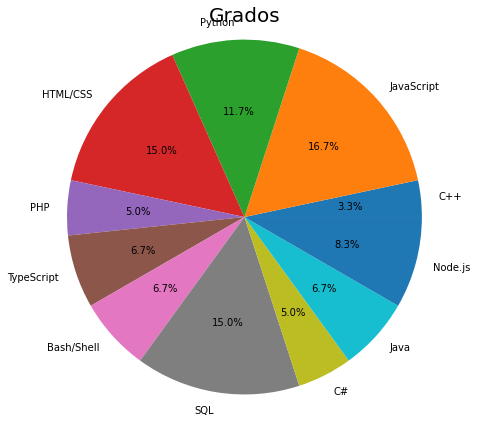

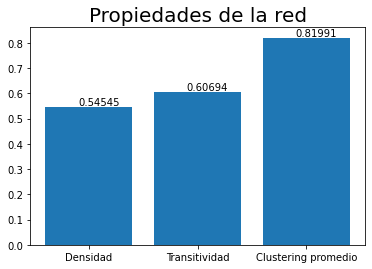

In [14]:
"""
ejecutar(0)
ejecutar(5)
ejecutar(10)
ejecutar(15)
ejecutar(20)
ejecutar(25)
ejecutar(30)
ejecutar(35)
ejecutar(40)
ejecutar(45)
ejecutar(50)
ejecutar(55)
ejecutar(60)
ejecutar(65)
ejecutar(70)
ejecutar(75)
ejecutar(80)
ejecutar(85)
ejecutar(90)
ejecutar(95)
ejecutar(100)
"""
ejecutar(30)